pip install --force-reinstall tensorflow

# SOMMAIRE

### Introduction

L'objectif de ce projet est d'entrainer un CNN capable de classer les images en fonction de la race du chien présent sur l'image, en utilisant notamment du Transfert Learning.  
Le dataset utilisé est le [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) .


1. [Imports et chemins](#-1.-Imports-et-chemins)
2. [Observation des données](#-2.-Observation-des-données)
3. [Preprocessing](#-3.-Preprocessing)
4. [Modèles CNN](#-4.-Modèles-CNN)
5. [Transfer Learning](#-5.-Transfer-Learning)

## 1. Imports et chemins

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Observation
from wordcloud import WordCloud

# Preprocessing
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Bibliothèques de base et outils TensorFlow/Keras
import tensorflow as tf
import keras
from keras import backend as K

# Outils de modélisation et couches de réseau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Input, Activation, Flatten, Dropout, Dense

# Importations pour le Transfer Learning
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB3

# Prétraitement et utilitaires
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Optimiseurs et Tuning
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# Métriques d'évaluation
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score


In [2]:
PATH_INPUT = "D:\\PROD_SAS\\03_Projets_CRM\\56_DOP\\01_FIDELISATION_CC\\p6\\input"
PATH_OUTPUT = "D:\\PROD_SAS\\03_Projets_CRM\\56_DOP\\01_FIDELISATION_CC\\p6\\output"
PATH_FIGURES = "D:\\PROD_SAS\\03_Projets_CRM\\56_DOP\\01_FIDELISATION_CC\\p6\\output\\figures"

In [3]:
# Unix : Il ne faut pas prendre en compte les fichiers cachés
list_breeds = [f for f in os.listdir(PATH_INPUT + "/Images") if not f.startswith('.')]

## 2. Observation des données

In [4]:
print(f"Nb de catégories/d'espèces de chiens :", len(list_breeds))

Nb de catégories/d'espèces de chiens : 120


In [5]:
# Production d'un df
 
df = pd.DataFrame(list_breeds, columns=['Id_name_breed'])
df['breed_name']=df['Id_name_breed'].apply(lambda x: x.split('-')[1])
df['Id']=df['Id_name_breed'].apply(lambda x: x.split('-')[0])

nb_pic=[]
for name in df.Id_name_breed:
   nb_pic.append(len(os.listdir(f"{PATH_INPUT}//Images" + "/" + name)))

df['nb_pic']=nb_pic

print("Nb total d'images:", df["nb_pic"].sum())

Nb total d'images: 20580


In [6]:
df.head(3)

Id_name_breed        breed_name         Id  nb_pic
0         n02085620-Chihuahua         Chihuahua  n02085620     152
1  n02085782-Japanese_spaniel  Japanese_spaniel  n02085782     185
2       n02085936-Maltese_dog       Maltese_dog  n02085936     252

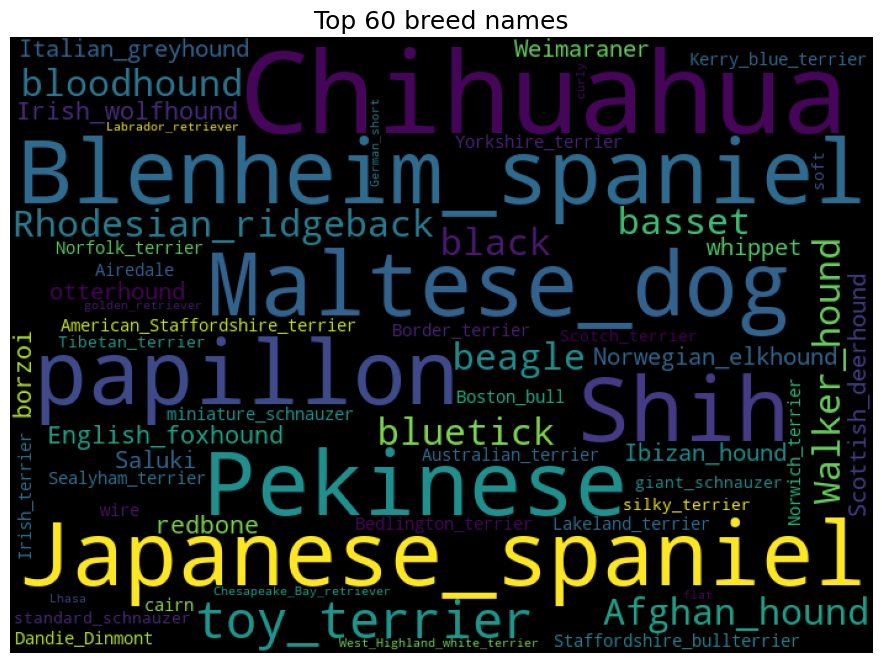

In [7]:
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",max_words=60, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(df.breed_name))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 60 breed names", fontsize=18)
plt.show()

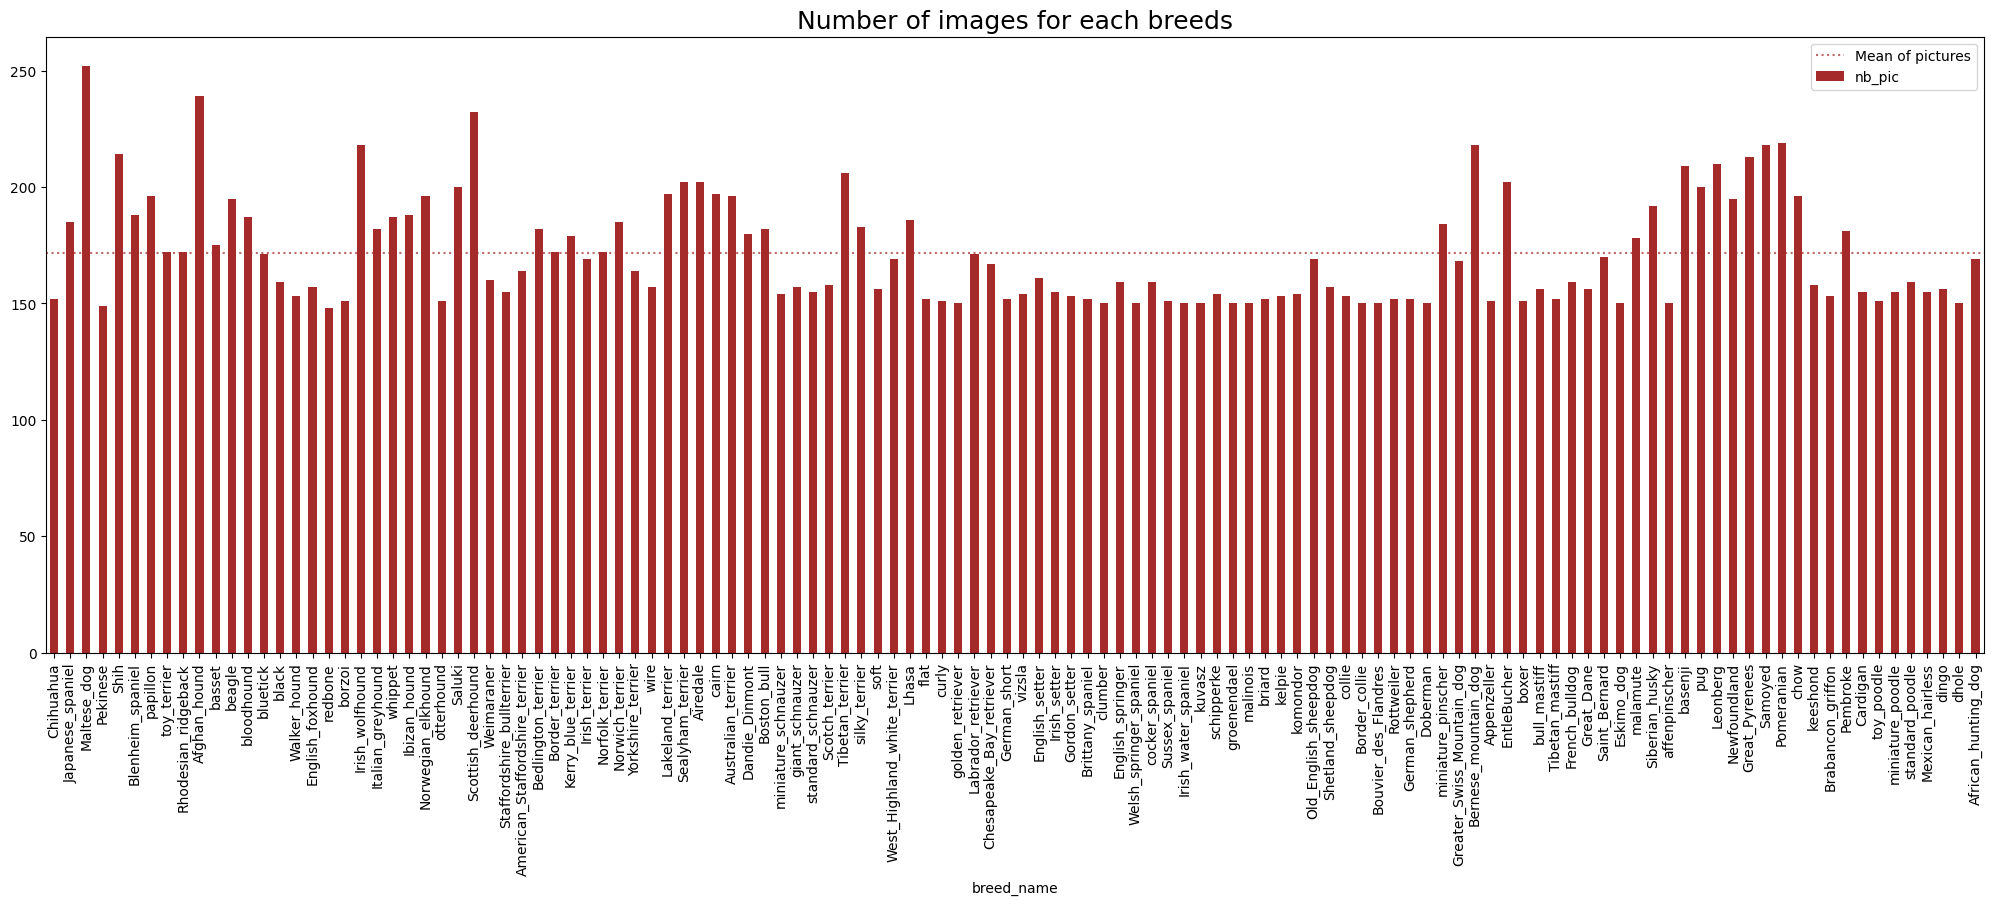

Le nb moyen d'images par classe est de 171.5
Le nb d'images par classe varie entre 148 et 252


In [8]:
fig, ax = plt.subplots(1, 1, figsize=(25,8))
df.plot(x='breed_name',kind="bar", color='brown',legend=False,ax=ax)
ax.axhline(df["nb_pic"].mean(),
           color='brown', alpha=.7,
           linestyle=':',
           label="Mean of pictures")
plt.title("Number of images for each breeds",
          color='k', fontsize=18)
plt.legend()
plt.show()

print("Le nb moyen d'images par classe est de", df["nb_pic"].mean())
print("Le nb d'images par classe varie entre", df["nb_pic"].min(), "et", df["nb_pic"].max())

In [9]:
import matplotlib.image as mpimg

In [10]:
#list of directories 
path_list=[]
for classe in df['Id_name_breed'].values:
    images = os.listdir(f"{PATH_INPUT}//Images" + "/" + classe)
    for i in range(len(images)):
        path_list.append(f"{PATH_INPUT}//Images"+"/"+ classe +"/"+images[i])
        
#list of images shape        
ds_img=[]
for path in path_list:
    ds_img.append(mpimg.imread(path).shape)

#data frame of results    
ds_img = pd.DataFrame(ds_img, index = path_list,columns=['heigth','width','color'])
#list of breed which corespoonds to each path      
y=[]
for j in range(len(list_breeds)):
   for k in range(df.nb_pic.values[j]):
      y.append(df.breed_name.values[j])
ds_img['breed_name']=y

In [11]:
ds_img.sample(10)

heigth  width  color  \
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     375    500      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     318    300      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     375    500      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     333    500      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     375    500      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     333    500      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     375    500      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     324    500      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     500    493      3   
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...     404    500      3   

                                                          breed_name  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...    French_bulldog  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...   German_shepherd  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...            kelpie  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...               pug  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...   Norwich_terrier  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...            beagle  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...  Brittany_spaniel  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...           clumber  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...    Scotch_terrier  
D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISATI...            borzoi

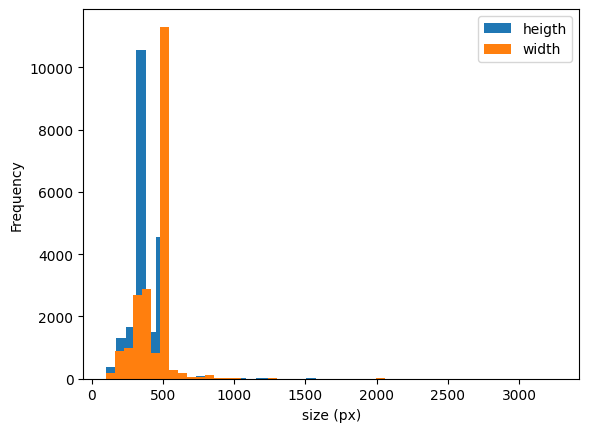

Larguer et hauteur moyennes par image :  (385.86, 442.53)


In [12]:
ds_img['heigth'].plot.hist(bins=35, alpha=1)
ds_img['width'].plot.hist(bins=50, alpha=1)
plt.xlabel('size (px)')
plt.legend(['heigth','width'])
plt.show()
print("Larguer et hauteur moyennes par image : ", (round(ds_img['heigth'].mean(),2),round(ds_img['width'].mean(),2)))

In [13]:
ds_img['color'].value_counts().values[0]

20579

In [14]:
# Obtenir les fréquences des couleurs dans le DataFrame
color_counts = ds_img['color'].value_counts().reset_index()
color_counts.columns = ['Couleur', 'Fréquence']

# Trier les couleurs par ordre décroissant de fréquence
color_counts = color_counts.sort_values(by='Fréquence', ascending=False)

print("Fréquence des couleurs dans le dataset :")
print(color_counts)

Fréquence des couleurs dans le dataset :
   Couleur  Fréquence
0        3      20579
1        4          1


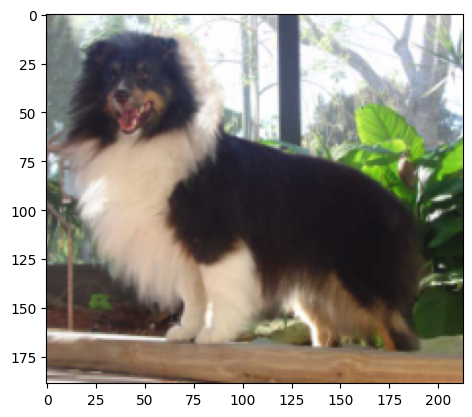

In [15]:
image_color_4 = ds_img[ds_img.color==4].index[0]
img4 = mpimg.imread(image_color_4)
plt.imshow(img4)

L'indice de couleur exprime en fait le niveau de transparence de l'image. Une seule est à 4, on remarque que c'est une image avec une transparence forte dans la partie supérieure droite.

(-0.5, 468.5, 346.5, -0.5)

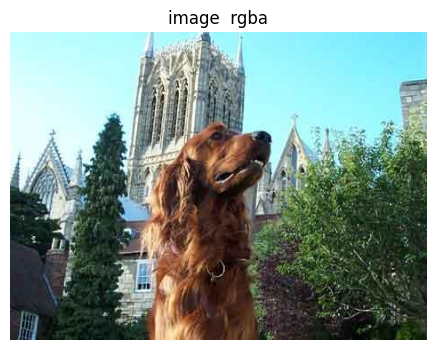

In [16]:
#Affichage d'une image au hasard
plt.fig = plt.figure(figsize=(10,4))
idx = ds_img[ds_img.color==3].index[random.randint(0,len(ds_img[ds_img.color==3]))]
img4 = mpimg.imread(idx)
plt.imshow(img4)
plt.title("image  rgba")
plt.axis('off')

Regardons quelques exemples des images par races disponibles dans notre base d'étude :

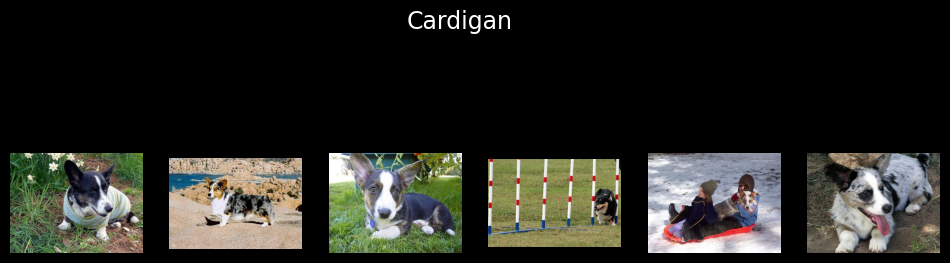

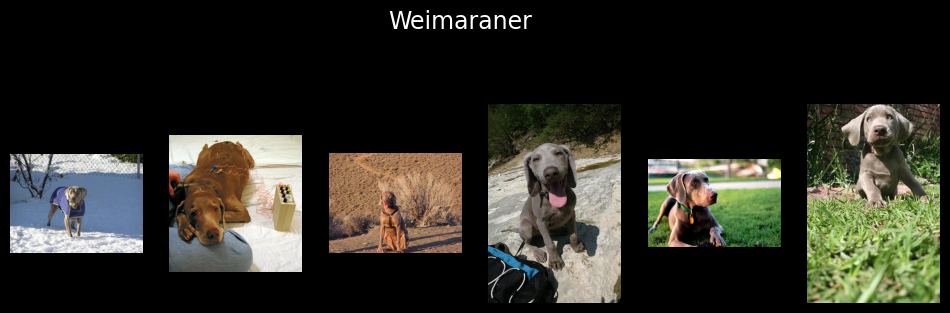

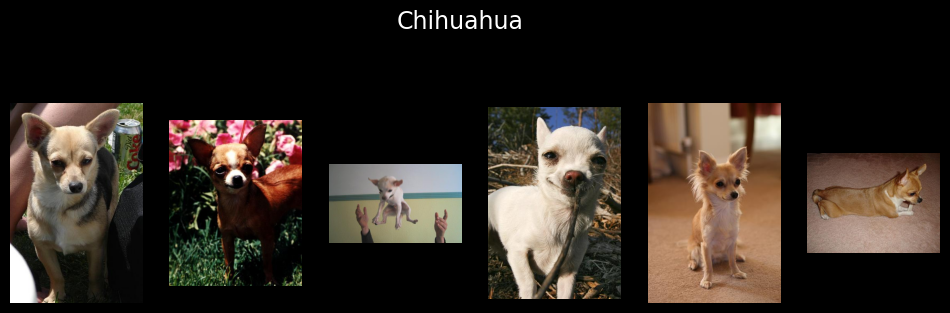

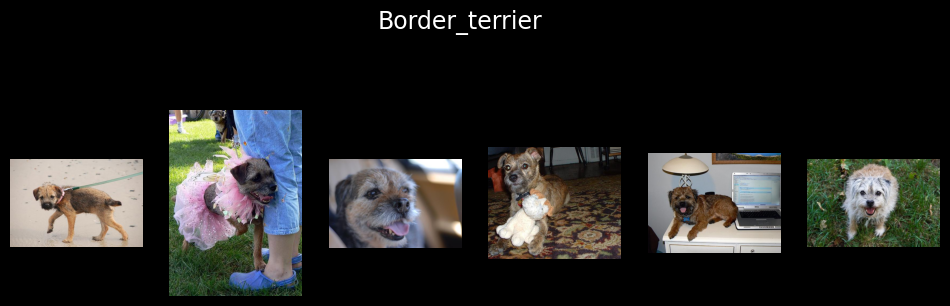

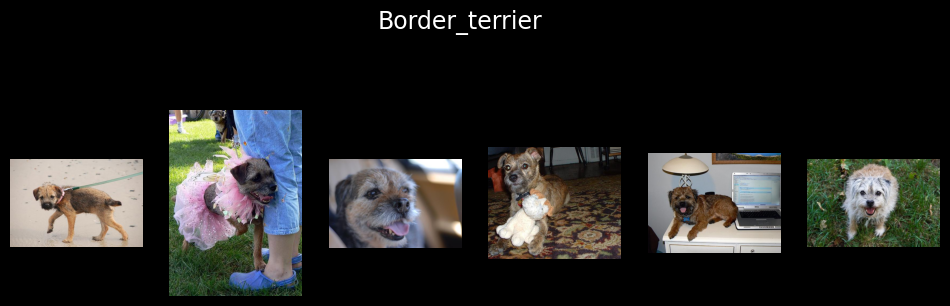

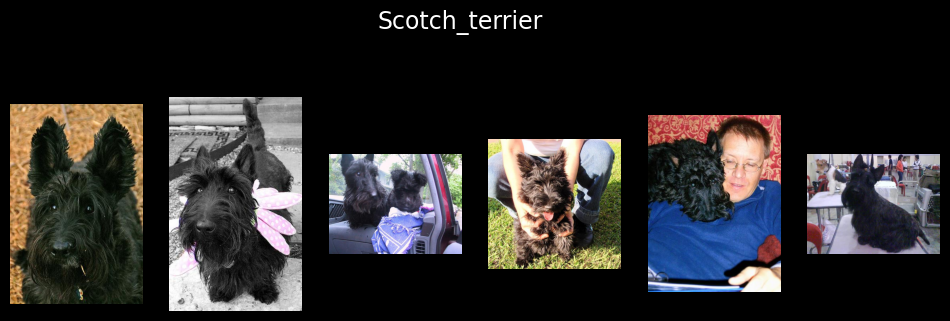

In [17]:
plt.style.use('dark_background')

Num = 6
breed_id_sample = np.random.choice(df['Id_name_breed'].values,Num)
for classe in breed_id_sample:
   images = os.listdir(f"{PATH_INPUT}//Images" + "/" + classe)[:Num]
   fig = plt.figure(figsize=(12,4))
   plt.suptitle("{}".format(classe.split("-")[1]), color="w", fontsize=17) 
   for i in range(Num):
        img = mpimg.imread(f"{PATH_INPUT}//Images"+"/"+ classe +"/"+images[i])
        plt.subplot(1, Num, i+1)
        plt.imshow(img)
        plt.axis('off')  
   plt.show()

La dimension des images n'est pas uniforme ; or le modèle CNN exige une taille unique pour toutes les données. Il faut donc redimensionner les images à une dimension unique. Nous choisissons la dimenstion standard 300*300.

Nous allons ainsi effectuer un ensemble de transformation sur notre base des images. Notamment, la redimensinnement, l'égalisation, le débruitage et le blanchiment.

## 3. Preprocessing

### 1.2.1 Egalisation d'histogramme

Il s'agit de mieux répartir l'intensité lumineuse dans l'ensemble de l'image : les images ternes seront éclairées, les images claires seront assombries.  Cela revient à égaliser un histogramme.  
  
![Histogramme](https://docs.opencv.org/4.x/histogram_equalization.png)  
  
Pour des images couleur, il faut procéder couleur par couleur : red, green, puis blue.

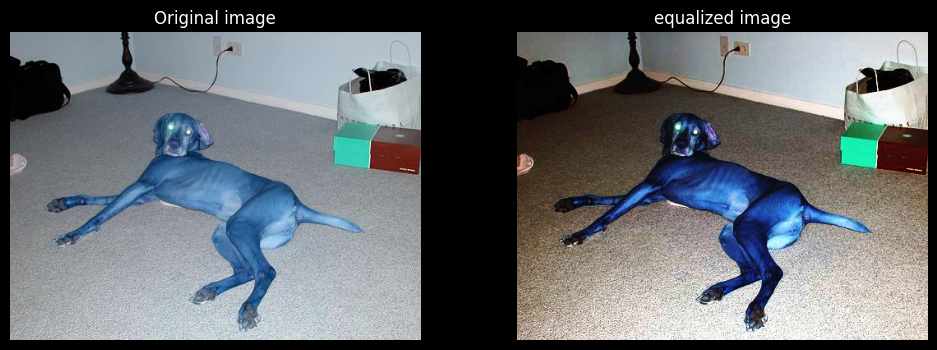

In [18]:
random_path = ds_img.index[np.random.randint(len(ds_img))]
image = cv2.imread(random_path)

# Equalization
r_image, g_image, b_image = cv2.split(image)
r_image_eq = cv2.equalizeHist(r_image)
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
cmap_val = None

# Show both images
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("equalized image")
plt.show()           

### 1.2.2 Débruitage de l'image

Une image peut être "bruitée", c-à-d avoir des pixels indésirables, du grain, en raison de la mauvaise qualité de l'appareil ou de conditions climatiques défavorables.  
Pour débruiter, OpenCV calcule les moyennes de blocs de pixels similaires (blocs avec les mêmes variations de couleur, les mêmes motifs...) et corrgie ensuite chaque bloc individuel. Cela homogénéise, enlève les détails spécifiques de chaque bloc mais limite aussi les "erreurs" du bruit.

Pour la méthode "fastNlMeansDenoisingColored", j'utilise des paramètres par défaut, retrouvés dans différentes explications sur le sujet, notamment sur la documentation [https://docs.opencv.org/4.x/d1/d79/group__photo__denoise.html].

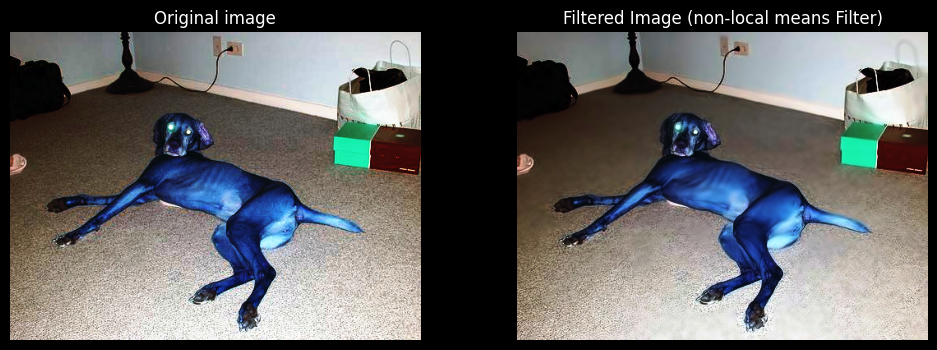

In [19]:
# Apply non-local means filter on test img
img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,21,7)
# Show both img
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(img_nlf)
plt.title("Filtered Image (non-local means Filter)")
plt.show()

### 1.2.3 Whitening

Le but du whitening est de supprimer la corrélation entre les pixels.  
Le whitening, contrairement à ce que son nom indique, n'aboutit pas forcément à une image en noir et blanc.

Le processus de whitening peut être résumé comme suit :

Calcul de la matrice de covariance : Tout d'abord, on calcule la matrice de covariance à partir des données d'entrée. La matrice de covariance représente les relations statistiques entre les différentes caractéristiques de l'ensemble de données.

Décomposition en valeurs propres et vecteurs propres : Ensuite, on effectue une décomposition en valeurs propres et vecteurs propres de la matrice de covariance. Cela permet de déterminer les directions principales (vecteurs propres) le long desquelles les données sont les plus étendues et les valeurs propres indiquent les variances associées à ces directions.

Normalisation des vecteurs propres : Les vecteurs propres sont normalisés pour avoir une longueur unitaire, ce qui permet d'obtenir une base orthonormée.

Réduction de la corrélation : Les données d'entrée sont projetées sur cette nouvelle base orthonormée, ce qui les rend décorrélées. Cela signifie que les nouvelles caractéristiques sont statistiquement indépendantes les unes des autres.

Ajustement de l'échelle : Enfin, les caractéristiques sont ajustées en échelle pour avoir une variance unitaire, ce qui est également appelé mise à l'échelle unitaire.

In [20]:
def whitening(image, eps):
    """Fonction qui calcule la transformation de blanchiment ZCA d'une image couleur
    --------------------
    param :
    image : image à traiter
    eps : seuil de blanchiment <1
    """

    # Suppression de la moyenne de chaque pixel
    image_c = image - image.mean(axis=0)

    # Séparation de l'image_c en 3 canaux de couleur
    r_image, g_image, b_image = cv2.split(image_c)

    # Calcul de la matrice de covariance des données centrées
    cov_r = np.cov(r_image, rowvar=False, bias=True)
    cov_g = np.cov(g_image, rowvar=False, bias=True)
    cov_b = np.cov(b_image, rowvar=False, bias=True)

    # Calcul de la décomposition en valeurs singulières (SVD) des matrices de covariance
    U_r, S_r, V_r = np.linalg.svd(cov_r)
    U_g, S_g, V_g = np.linalg.svd(cov_g)
    U_b, S_b, V_b = np.linalg.svd(cov_b)

    # Transformation de whitening en utilisant ZCA (Zero Component Analysis)
    r_img_zca = U_r.dot(np.diag(1.0 / np.sqrt(S_r + eps))).dot(U_r.T).dot(r_image.T).T
    g_img_zca = U_g.dot(np.diag(1.0 / np.sqrt(S_g + eps))).dot(U_g.T).dot(g_image.T).T
    b_img_zca = U_b.dot(np.diag(1.0 / np.sqrt(S_b + eps))).dot(U_b.T).dot(b_image.T).T

    # Recomposition de l'image
    img_zca = cv2.merge((r_img_zca, g_img_zca, b_img_zca)) + image.mean(axis=0) / 255

    return img_zca

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


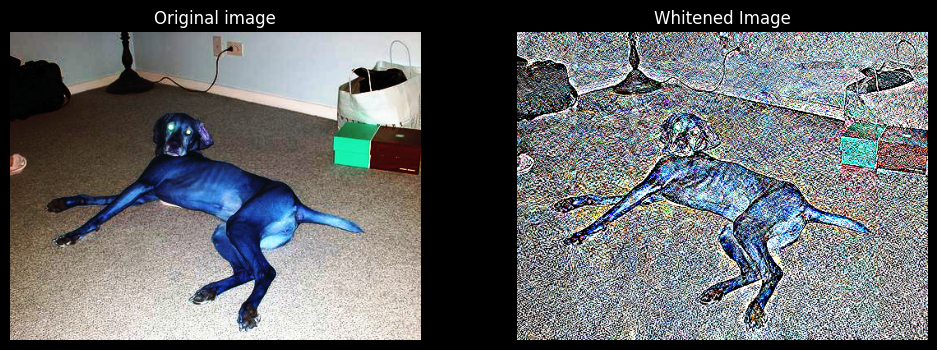

In [21]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off') 
plt.imshow(image_eq)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.axis('off') 
plt.imshow(whitening(image, 0.01),cmap='Greys')
plt.title("Whitened Image")
plt.show()

### 1.2.4 Augmentation de données

L'objectif est de produire de nouvelles images depuis des images existantes afiin d'augmenter la base de données.  
Il s'agit d'appliquer des transformations géométriques aléatoires : translations, rotations, mirroring, ...

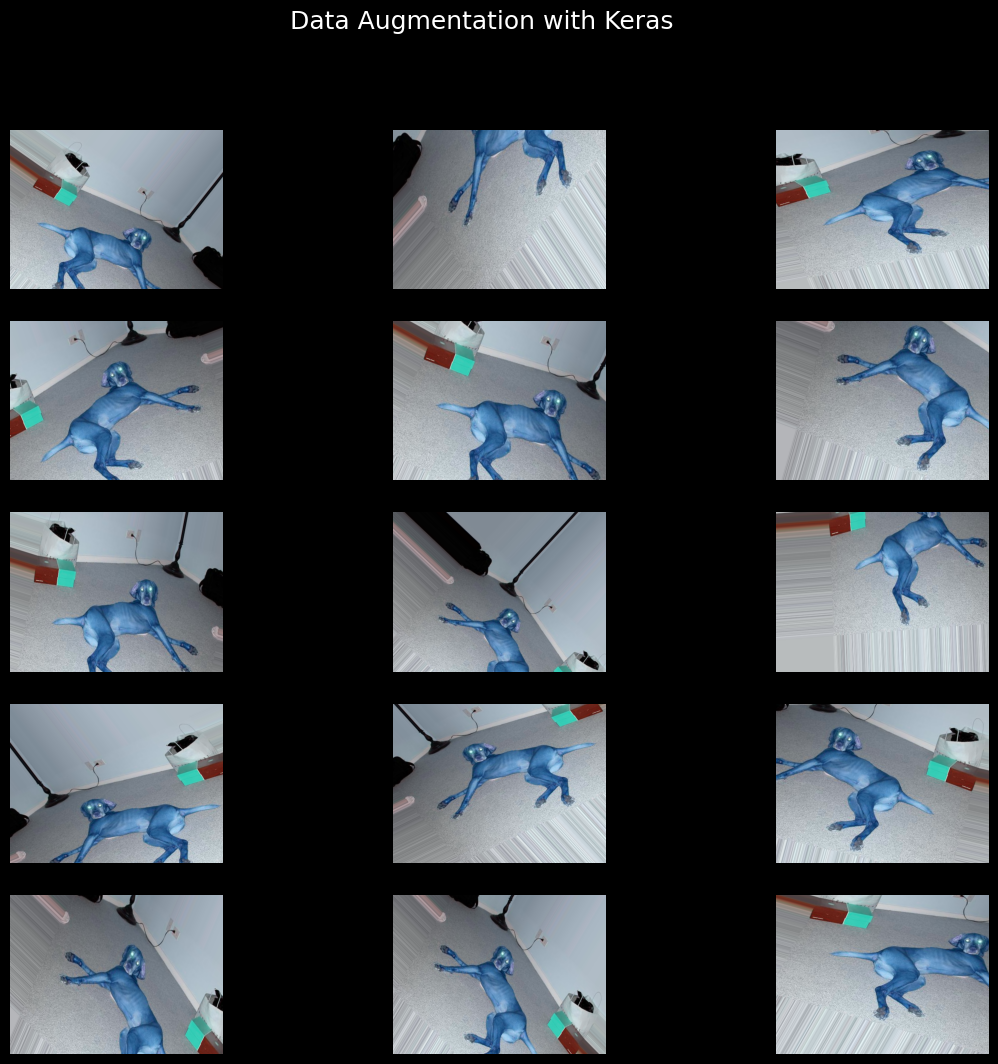

In [22]:
# Création du générateur d'images
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        fill_mode='nearest')

# Convert an image to array
x = image.reshape((1,) + image.shape)

# Generate batches of augmented images from `x`
fig = plt.figure(figsize=(14,12))
for i, batch in enumerate(datagen.flow(x, batch_size=1)):

    # We only want the first 15 batches, so break the loop after that
    if i == 15:
        break

    # Get the subplot for the current batch and display it
    ax = fig.add_subplot(5, 3, i+1)
    ax.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))

    plt.axis('off') 


plt.suptitle("Data Augmentation with Keras", fontsize=18)
plt.show()

## 4. Modèles CNN

Plusieurs paramètres doivent être définis pour entrainer un modèle CNN : 
- __le type de fonction d'activation__ : elle introduit de la non-linéarité dans le modèle et détermine l'output d'un neurone dans le réseau
- __l'algorithme d'optimisation__ : méthode utilisée pour ajuster les poids du réseau afin de minimiser la fonction de coût
- __le nb de filtres__ (sur la couche de convolution)/nb de kernel : chaque filtre est capable de détecter une caractéristique spécifique dans l'image (par exemple, les bords, les couleurs, etc.). Un nombre plus élevé de filtres permet au réseau d'apprendre une plus grande variété de caractéristiques, mais augmente également la complexité du modèle.
- __le Wind__ : taille de la fenêtre d'entrée sur laquelle le filtre de convolution est appliqué. Par exemple, une taille de fenêtre de 3 signifie que le filtre est appliqué sur des carrés de 3x3 pixels à la fois. La taille de la fenêtre influence le niveau de détail que le réseau peut apprendre : une taille de fenêtre plus petite permet de capturer des détails fins, tandis qu'une taille plus grande permet de capturer des caractéristiques plus globales.
- __le nb d'Epochs__ : nb de fois l'ensemble du jeu de données est passé au travers du réseau neuronal

Il va falloir déterminer quels sont les paramètres les plus performants dans notre cas.

Les mesures classiques d'évaluation d'un modèle CNN sont :
- __Accuracy__ : indique la performance du modèle à travers la proportion d'observations correctement classées par rapport à toutes les observations
- __Loss__ : mesure la manière dont le modèle s'ajuste aux données. Une perte élevée indique un surajustement, une perte faible est bon signe.

### 1 - Préparation

In [24]:
def preprocessing(uri_list,input_shape):
    """Preprocessing of images for convolutional neural network.
    Equalization, Denoising and transformation of the image into Array. 
    ------------------
    param:
    uri_list: 
    list of images directories
    input_shape: 
    (width, heigth) size of the image  for target resizing
    """
    img_list=[]
    for uri in uri_list:
            # Read image
            image = cv2.imread(uri)
            # Resize image
            image = cv2.resize(image, input_shape)
            # Equalization
            r_image, g_image, b_image = cv2.split(image)
            r_image_eq = cv2.equalizeHist(r_image)
            g_image_eq = cv2.equalizeHist(g_image)
            b_image_eq = cv2.equalizeHist(b_image)
            image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
            # Apply non-local means filter 
            img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,7,21)
            img_nlf = whitening(img_nlf, 0.01)
            # Append lists of labels and image
            img_list.append(img_nlf)
            #labels = ds_img.bread_name[0:tot_nb_img]
        
  
    return np.array(img_list)

In [28]:
# On testera sur les 5 races avec les plus d'images

NB_BREEDS = 5
fr_breed_list = df.nlargest(NB_BREEDS,'nb_pic')['breed_name']
fr_breed_list

2             Maltese_dog
9            Afghan_hound
26     Scottish_deerhound
107            Pomeranian
19        Irish_wolfhound
Name: breed_name, dtype: object

In [30]:
data_cnn=ds_img[ds_img['breed_name'].isin(fr_breed_list)].reset_index()[['index','breed_name']]

index   breed_name
0     D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...  Maltese_dog
1     D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...  Maltese_dog
2     D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...  Maltese_dog
3     D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...  Maltese_dog
4     D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...  Maltese_dog
...                                                 ...          ...
1155  D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...   Pomeranian
1156  D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...   Pomeranian
1157  D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...   Pomeranian
1158  D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...   Pomeranian
1159  D:\PROD_SAS\03_Projets_CRM\56_DOP\01_FIDELISAT...   Pomeranian

[1160 rows x 2 columns]

In [32]:
data_cnn.rename(columns={"index":"image_path"}, inplace=True)
uri_list=data_cnn['image_path'] # liens sur l'ordinateur des différentes photos
label_list=data_cnn['breed_name']

In [34]:
X = preprocessing(uri_list, (224,224))
y = label_list
# Convert data in numpy array
y = np.array(y)

# Dans un modèle CNN, les labels doivent être numériques. Il faut les encoder.
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [35]:
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

# Passage des y de int en categ
y_train_encoded = to_categorical(y_train, num_classes=NB_BREEDS)
y_test_encoded = to_categorical(y_test, num_classes=NB_BREEDS)

In [37]:
# Callbacks
checkpoint_cb  = keras.callbacks.ModelCheckpoint("Best_Model_1.h5",monitor='loss',
                                                 verbose=1,save_best_only=True,mode='min')

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.001,
                                                  patience=10,verbose=1,mode='auto')

callbacks = [checkpoint_cb, early_stopping_cb]

### 2 - Définition et entrainement des modèles

#### 1) 1er modèle

In [ ]:
# Modèle sommaire, proposé par l'IA

In [ ]:
def create_model(NB_BREEDS):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(300, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(NB_BREEDS, activation='softmax')) 
    
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = create_model(NB_BREEDS)
history = model.fit(X_train, y_train_encoded, epochs=50, validation_data=(X_test, y_test_encoded), batch_size=32, callbacks=callbacks)

Epoch 1/50


24/24 [==============================] - ETA: 0s - loss: 1.6468 - accuracy: 0.2326
Epoch 1: loss did not improve from 0.00144
24/24 [==============================] - 54s 2s/step - loss: 1.6468 - accuracy: 0.2326 - val_loss: 1.5961 - val_accuracy: 0.2513
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 1.5768 - accuracy: 0.2746
Epoch 2: loss did not improve from 0.00144
24/24 [==============================] - 51s 2s/step - loss: 1.5768 - accuracy: 0.2746 - val_loss: 1.5927 - val_accuracy: 0.2880
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 1.5519 - accuracy: 0.2957
Epoch 3: loss did not improve from 0.00144
24/24 [==============================] - 51s 2s/step - loss: 1.5519 - accuracy: 0.2957 - val_loss: 1.6093 - val_accuracy: 0.2618
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 1.4889 - accuracy: 0.3627
Epoch 4: loss did not improve from 0.00144
24/24 [==============================] - 52s 2s/step - loss: 1.4889 - accura

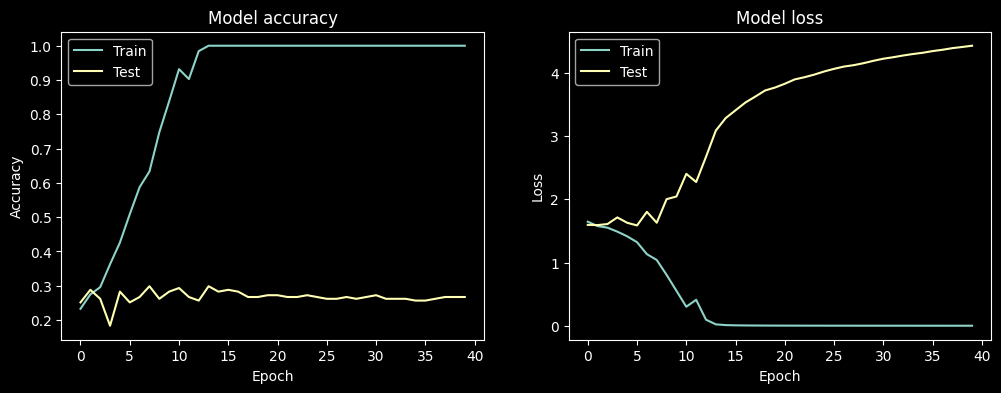

In [ ]:
def plot_results(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

plot_results(history)

#### 2) 2e modèle

On utilise un modèle plus complexe, plus proche de vgg19, mais surtout avec un fine-tuning opéré avec kt.Hyperband

In [ ]:
def model_builder(hp) :
   """
   """
   
   K.clear_session()
   model = Sequential()

   strd=2
   nb_breed=5
   # Tune the number of filters for the second Conv2D 
   hp_filters = hp.Choice('num_filters', values=[4,8,16], default=4,)

   # Tune the activation function for Dense layer
   hp_activation= hp.Choice( "dense_activation", values=["relu", "selu","tanh", "sigmoid"], default="relu" )

   # Tune the size
   hp_kernel= hp.Choice( "kernel_size", values=[3,4,5], default=4 )

    # Tune the pooling size
   hp_wind= hp.Choice( "window_size", values=[3,4,5], default=4 )


   # 1.Convolution layer
   model.add(Conv2D(filters=hp_filters, kernel_size=hp_kernel, input_shape=(224, 224, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(hp_activation))
   # Pooling layer
   model.add(MaxPooling2D(pool_size= hp_wind, strides=(strd,strd), padding='same'))
   # 2.Second convolution layer
   model.add(Conv2D(filters=2*hp_filters, kernel_size=hp_kernel, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(hp_activation))
   # Pooling layer
   model.add(MaxPooling2D(pool_size=hp_wind, strides=(strd,strd), padding='same'))
   # 3.Third convolution layer
   model.add(Conv2D(filters=4*hp_filters , kernel_size=hp_kernel, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(hp_activation))
   # Pooling layer
   model.add(MaxPooling2D(pool_size=hp_wind, strides=(strd,strd), padding='same'))
   # 4.Fourth convolution layer
   model.add(Conv2D(filters=8*hp_filters , kernel_size=hp_kernel, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(hp_activation))
   model.add(GlobalAveragePooling2D())
   model.add(Dropout(0.4))
   model.add(Flatten())
   # Fully connected layers
   model.add(Dense(16*hp_filters, activation=hp_activation))
   model.add(Dense(nb_breed, activation='softmax'))

   # Tune the learning rate for the optimizer 
   # Choose an optimal value from 0.01, 0.001, or 0.0001
   hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
   model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
  
   return model

In [ ]:
## Choix des meilleurs hyperparamètres
# Fine-tuning : le Hyperband fine-tune
tuner0 = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 5,
                     factor = 3,
                     directory = 'Models',
                     project_name = 'base_model_7') 

Reloading Tuner from Models\base_model_7\tuner0.json


In [ ]:
best_hps0 = tuner0.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
- The optimal number of filter Convolutional layer : {best_hps0.get('num_filters')}
\n - Best activation function : {best_hps0.get('dense_activation')}
\n - The optimal learning rate for the optimizer is {best_hps0.get('learning_rate')}
\n - Optimal kernel size : {best_hps0.get('num_filters')}
\n - Optimal window size : {best_hps0.get('window_size')}
""")


- The optimal number of filter Convolutional layer : 4

 - Best activation function : sigmoid

 - The optimal learning rate for the optimizer is 0.01

 - Optimal kernel size : 4

 - Optimal window size : 4



In [ ]:
best_model0 = tuner0.hypermodel.build(best_hps0)

In [ ]:
history0 = best_model0.fit(X_train, y_train,
                     validation_data=( X_test, y_test),
                     steps_per_epoch=len(X_train)/32, epochs=50, callbacks=callbacks)

Epoch 1/50


19/19 [==============================] - 13s 569ms/step - loss: 1.6633 - accuracy: 0.2204 - val_loss: 1.6413 - val_accuracy: 0.2026
Epoch 2/50
19/19 [==============================] - 10s 543ms/step - loss: 1.6045 - accuracy: 0.2566 - val_loss: 1.6440 - val_accuracy: 0.2680
Epoch 3/50
19/19 [==============================] - 10s 547ms/step - loss: 1.5985 - accuracy: 0.2796 - val_loss: 1.7556 - val_accuracy: 0.1895
Epoch 4/50
19/19 [==============================] - 10s 541ms/step - loss: 1.5688 - accuracy: 0.2961 - val_loss: 1.6003 - val_accuracy: 0.3007
Epoch 5/50
19/19 [==============================] - 10s 545ms/step - loss: 1.5400 - accuracy: 0.3388 - val_loss: 1.6292 - val_accuracy: 0.2026
Epoch 6/50
19/19 [==============================] - 10s 542ms/step - loss: 1.5160 - accuracy: 0.3306 - val_loss: 2.1441 - val_accuracy: 0.1895
Epoch 7/50
19/19 [==============================] - 10s 540ms/step - loss: 1.5068 - accuracy: 0.3306 - val_loss: 2.0432 - val_accuracy: 0.2026
Epoch 8/50

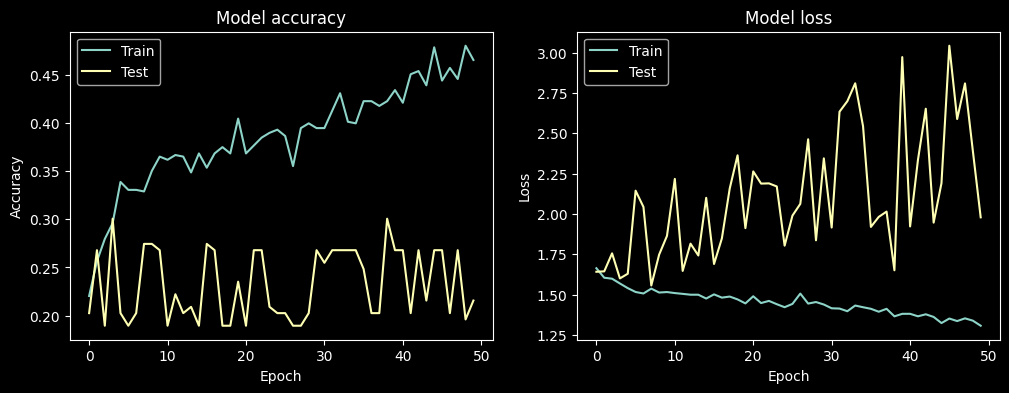

In [ ]:
plot_results(history0)

Meilleurs résultats. Le modèle avec davantage de couches est plus performant, et l'utilisation de kt.HyperBand est meilleure également.

### Data Augmentation sur 5 races

In [ ]:
train_gen2 = datagen.flow(X_train, y_train, batch_size=16)

In [ ]:
best_model0 = tuner0.hypermodel.build(best_hps0)

In [ ]:
history2 = best_model0.fit(train_gen2,
                     validation_data=(X_test, y_test),
                     steps_per_epoch=len(X_train)/32, epochs=50,
                     callbacks=callbacks)

Epoch 1/50
19/19 [==============================] - 9s 416ms/step - loss: 1.7167 - accuracy: 0.0164 - val_loss: 1.7656 - val_accuracy: 0.0000e+00
Epoch 2/50
19/19 [==============================] - 8s 397ms/step - loss: 1.6224 - accuracy: 0.0296 - val_loss: 1.6099 - val_accuracy: 0.0000e+00
Epoch 3/50
19/19 [==============================] - 8s 400ms/step - loss: 1.6315 - accuracy: 0.0000e+00 - val_loss: 1.6371 - val_accuracy: 0.0000e+00
Epoch 4/50
19/19 [==============================] - 7s 381ms/step - loss: 1.6379 - accuracy: 0.1549 - val_loss: 1.6350 - val_accuracy: 0.0000e+00
Epoch 5/50
19/19 [==============================] - 7s 372ms/step - loss: 1.5878 - accuracy: 0.0000e+00 - val_loss: 1.6322 - val_accuracy: 0.0000e+00
Epoch 6/50
19/19 [==============================] - 7s 379ms/step - loss: 1.6309 - accuracy: 0.0000e+00 - val_loss: 1.6998 - val_accuracy: 0.0000e+00
Epoch 7/50
19/19 [==============================] - 7s 379ms/step - loss: 1.5894 - accuracy: 0.0066 - val_loss: 

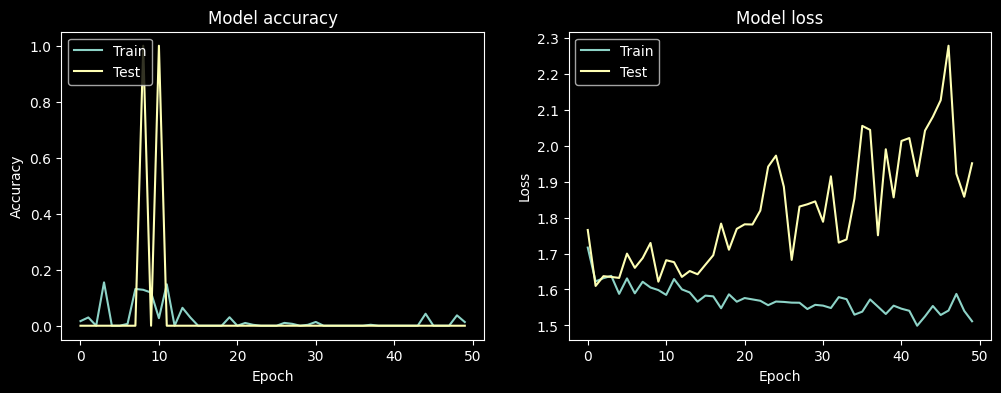

In [ ]:
plot_results(history2)

La Data Augmentation n'a amélioré ni l'accuracy ni la loss.

Ces approches ont leurs limites : on teste donc le Transfer Learning

## 5. Transfer Learning

Documentation sur les différents modèles : https://keras.io/api/applications/xception/

- <b>VGG19</b>  
Modèle facile à comprendre avec des couches similaires les unes aux autres.  
Inconvénients : lenteur et demande des ressources importantes.

- <b>Xception</b>  
L'intérêt du IXception est d'éviter le pb de disparition du gradient, commun dans le cas de réseau neurones profonds.  
Il capture des détails à différentes échelles.  
Inconvénient : demande un peu plus de temps de calcul.  
L'input size par défaut de ResNet est 224*224.

- <b>Resnet50</b>  
L'intérêt du ResNet est d'éviter le pb de disparition du gradient, commun dans le cas de réseau neurones profonds.  
Il peut "sauter" des connexions entre certains neurones, ce qui lui fait éviter le pb de disparition du gradient
L'input size par défaut de ResNet est 224*224.

In [41]:
def preprocess_func(model_name):
    
    if model_name == 'ResNet50':
        preprocessing_function = tf.keras.applications.resnet50.preprocess_input
    elif model_name == 'VGG19':
        preprocessing_function = tf.keras.applications.vgg19.preprocess_input
    elif model_name == 'EfficientNetB3':
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    else:
        preprocessing_function = tf.keras.applications.xception.preprocess_input

    return preprocessing_function  

In [43]:
# Test sans fine tune et sans data augmentation

In [44]:
#Dataframe to compare models
model_names = ['ResNet50', "VGG19", "EfficientNetB3", "Xception"]
dt_compar = pd.DataFrame([], index= model_names, 
                                      columns=['time_of_fit (s)', 'accuracy_train', 'accuracy_val', 'accuracy_test', 'recall_test' ])

In [45]:
def TF_CNN(model_name, nb_classes):
   
  # Import the model pretrained without fully-connected layers
  if model_name == 'ResNet50':
    model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
  elif model_name == 'VGG19':
    model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
  elif model_name == 'EfficientNetB3':
    model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300,300,3))
  else:
    model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))

  for layer in model.layers:
    layer.trainable = False   # Pour ne pas réentrainer les couches du TL

  #Define tf model with a new fully-connected layers
  tf_model = Sequential()
  tf_model.add(model)
  tf_model.add(GlobalAveragePooling2D())
  tf_model.add(Dense(512, activation='relu'))
  tf_model.add(Dropout(0.2))
  tf_model.add(Dense(nb_classes, activation='softmax'))

  # Compiles the model for training.
  tf_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['val_accuracy'])
  return tf_model

In [46]:
def resize_X(model_name):
    if model_name in ['ResNet50', "VGG19"]:
        X = preprocessing(uri_list, (224,224))
    elif model_name == 'EfficientNetB3':
        X = preprocessing(uri_list, (300,300))
    else:
        X = preprocessing(uri_list, (299,299))
    return X

In [47]:
#Séparation jeux entraînement/test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

In [ ]:
%%time
import time
result = {}
predict ={}
nb_classes = 5

for model_name in model_names:
  K.clear_session()
  start_time = time.time()
  tf_cnn = TF_CNN(model_name, nb_classes)

  # Création du X
  X = resize_X(model_name)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)
  # fit model
  result_cnn = tf_cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
          steps_per_epoch=len(X_train) / 32, epochs=50, batch_size=32, verbose=2,
          callbacks=callbacks)
  fit_time = round(time.time() - start_time,1)
  
  #compute and store scores
  dt_compar.loc[model_name, 'time_of_fit (s)'] = fit_time
  dt_compar.loc[model_name, 'accuracy'] = result_cnn.history['accuracy'][-1]
  dt_compar.loc[model_name, 'accuracy_val'] = result_cnn.history['val_accuracy'][-1]

  # store result
  result[model_name] = result_cnn

In [ ]:
def plot_scores_curves(result, Columns, name):
  """
  function which plots scores curves for various values paramater in the list Columns
  #--------------
  param:
  result: dictionary of history results of cnn model
  Columns : list of values parameter
  param: name of the parameter in analysis
  """
  # 
  val_loss = {k:v.history['val_loss'] for k,v in result.items()}
  val_acc = {k:v.history['val_accuracy'] for k,v in result.items()}

  val_loss_curves = pd.DataFrame(val_loss)
  val_loss_curves.columns =Columns
  val_acc_curves = pd.DataFrame(val_acc)
  val_acc_curves.columns =Columns
  sns.set_style("whitegrid")

  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  for col in Columns:
     ax[0].plot(val_loss_curves[col], label=col)
     ax[1].plot(val_acc_curves[col], label=col)
  
  ax[0].set_title("Impact of " + name +  " on the loss")
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[1].set_title("Impact of " + name +  " on the accuracy ")
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.show()

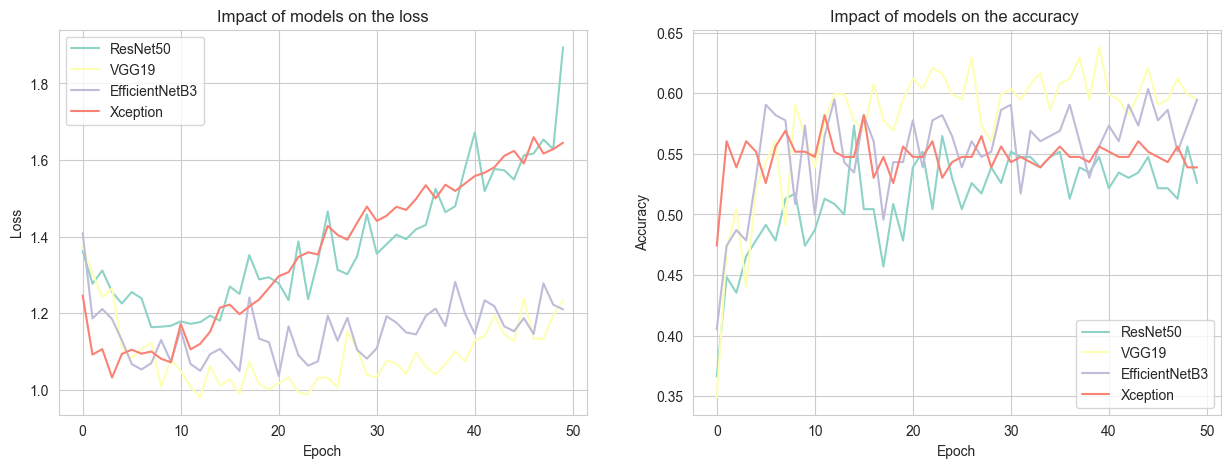

In [ ]:
result = result
Columns = model_names
name = 'models'
plot_scores_curves(result, Columns, name)

In [ ]:
dt_compar

time_of_fit (s) accuracy_train accuracy_val accuracy_test  \
ResNet50                3780.0       0.974138     0.525862           NaN   
VGG19                   8172.7       0.927802     0.594828           NaN   
EfficientNetB3          7513.4       0.828664     0.594828           NaN   
Xception                6841.4            1.0     0.538793           NaN   

               recall_test  
ResNet50               NaN  
VGG19                  NaN  
EfficientNetB3         NaN  
Xception               NaN

Le meilleur modèle est VGG19.

In [ ]:
# Relance le meilleur modèle

model_name ="VGG19"
tf_cnn = TF_CNN(model_name, nb_classes)

# Création du X
X = resize_X(model_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)
# fit model
result_cnn = tf_cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
        steps_per_epoch=len(X_train) / 32, epochs=50, batch_size=32, verbose=2,
        callbacks=callbacks)

# Chargement du modèle sauvegardé
from keras.models import load_model
saved_model = load_model('Best_Model_1.h5')

In [52]:
# Sauvegarde finale du modèle
saved_model.save('model_complete.h5')